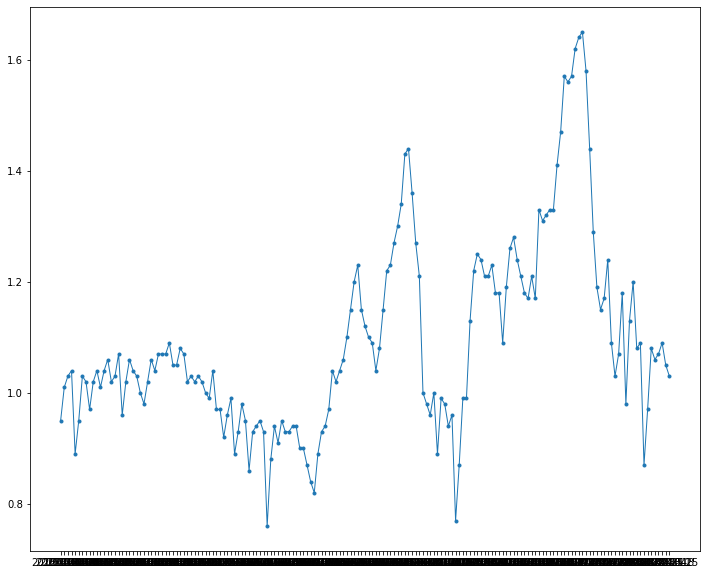

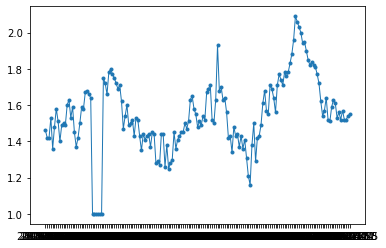

In [131]:
import importlib
import data_transform
import Cross_validation
importlib.reload(data_transform)
importlib.reload(Cross_validation)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Visualization.Feature_importance import FeatImp
from data_transform import apply_transformations,detect_outliers
from Cross_validation import cross_validation,BlockingTimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

#Models for predicting
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor,VotingRegressor
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#Grid Search
from sklearn.model_selection import GridSearchCV

# preparing and cleaning data
data = pd.read_csv('data/avocado.csv')
data_us = data[data["region"] == "TotalUS"]
data_us = data_us.sort_values(by=['Date'])
data_con_us = data_us[data_us["type"] == "conventional"]
data_org_us = data_us[data_us["type"] == "organic"]
dates_us = data_org_us['Date']
target_con_us = data_con_us['AveragePrice']
target_org_us = data_org_us['AveragePrice']

plt.figure(figsize=(12,10))
plt.plot(dates_us,target_con_us,lw=1,marker='.')
plt.show()
plt.plot(dates_us,target_org_us,lw=1,marker='.')
plt.show()
data_con_us = data_con_us.drop(['type','Unnamed: 0','region'],axis = 1)

In [132]:

# split date: day,month,year 
liste = []
for date in data_con_us['Date']:
    liste.append(date.split("-"))
# month and day adding to lists
month = []
day = []
for i in range(len(liste)):
    month.append(liste[i][1])
    day.append(liste[i][2])
    
# adding to dataset
data_con_us["month"] = month
data_con_us["day"] = day

# delete old date column
data_con_us.drop(["Date","AveragePrice"],axis=1,inplace=True)

#convert objects to int
#data_con_us['month'] = data_con_us['month'].values.astype(int)
#data_con_us['day'] = data_con_us['day'].values.astype(int)
data_con_us['year'] = data_con_us['year'].values.astype(str)
data_con_us = pd.get_dummies(data_con_us,drop_first=True)

In [133]:
num_columns = data_con_us.iloc[:,0:8].columns.values
num_columns
data_con_us[num_columns] = np.log10(data_con_us[num_columns] +1 )
data_con_us

,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year_2016,year_2017,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2703,7.495881,7.091919,7.134307,5.926391,6.653110,6.554528,5.951797,4.271233,0,0,...,0,0,0,0,0,0,0,0,0,0
2702,7.463349,7.062387,7.084032,5.937806,6.654887,6.577866,5.856327,4.198386,0,0,...,0,0,0,0,0,0,0,0,0,0
2701,7.463048,7.074017,7.068258,5.919759,6.667646,6.588052,5.887107,3.899621,0,0,...,0,0,0,0,0,0,0,0,0,0
2700,7.454392,7.085199,7.030788,5.885373,6.681259,6.599734,5.910051,3.936127,0,0,...,0,0,0,1,0,0,0,0,0,0
2699,7.649875,7.277220,7.277758,6.140356,6.731140,6.624947,6.049636,4.671174,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9094,7.602294,7.140818,7.017679,5.859937,7.177591,7.028040,6.610809,5.482213,0,0,...,0,0,0,1,0,0,0,0,0,0
9093,7.610034,7.159554,7.052667,5.757205,7.159586,7.034745,6.523645,5.428928,0,0,...,0,0,0,0,0,0,0,0,0,0
9092,7.606914,7.148883,7.031733,5.849775,7.173037,7.056632,6.509143,5.435381,0,0,...,0,0,0,0,0,0,0,0,0,0
9091,7.616857,7.136955,7.043796,5.809817,7.203373,7.068661,6.600766,5.433904,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
from sklearn.preprocessing import StandardScaler

train_size_start = int(0.0*len(data_con_us))
train_size_end = int(0.7*len(data_con_us))
test_size_end = int(1*len(data_con_us))
#train data
X_train = data_con_us[:][train_size_start:train_size_end]
y_train = target_con_us[train_size_start:train_size_end]

# test data
X_test = data_con_us[:][train_size_end:test_size_end]
y_test = target_con_us[train_size_end:test_size_end]

SC = StandardScaler()
X_train = SC.fit_transform(X_train)
X_test = SC.transform(X_test)

SC_y = StandardScaler()
y_train = pd.Series(SC_y.fit_transform(np.array(y_train).reshape(-1,1)).ravel()) # same goes for target values!!!
y_test = pd.Series(SC_y.transform(np.array(y_test).reshape(-1,1)).ravel())



-0.1543940392108838


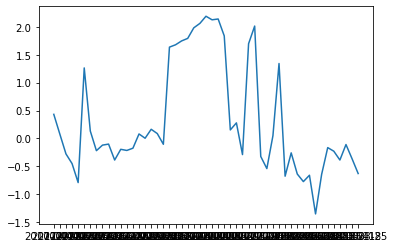

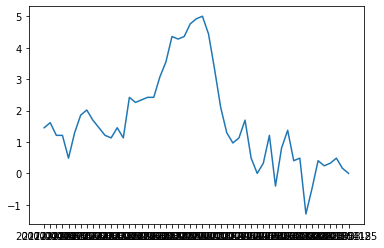

In [165]:
from sklearn.metrics import r2_score
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)
predictions = RFR.predict(X_test)
print(r2_score(y_test,predictions))
plt.plot(dates_us[train_size_end:test_size_end],predictions)
plt.show()
plt.plot(dates_us[train_size_end:test_size_end],y_test)

In [169]:

RFR = RandomForestRegressor()
btss = BlockingTimeSeriesSplit(n_splits=5)

rfr_params = {"n_estimators":[10,20,50,100,200],
              "criterion":['mse','mae'],
              "max_depth":[4,6,8,10,20],
             }
gsRFC = GridSearchCV(RFR,param_grid = rfr_params, cv=btss, scoring="r2", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   16.9s finished


-0.323095897998263


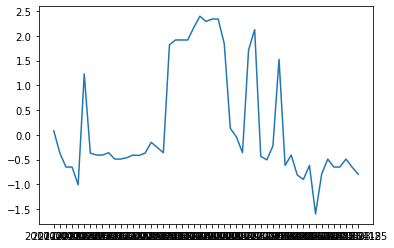

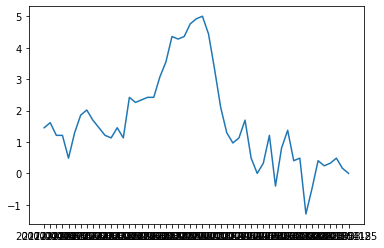

In [170]:
RFC_best.fit(X_train,y_train)
predictions = RFC_best.predict(X_test)
print(r2_score(y_test,predictions))
plt.plot(dates_us[train_size_end:test_size_end],predictions)
plt.show()
plt.plot(dates_us[train_size_end:test_size_end],y_test)

0.008397850637927973


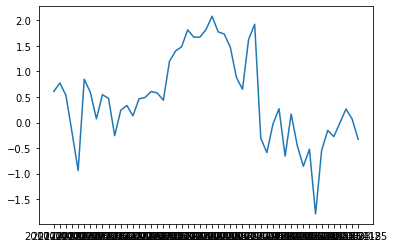

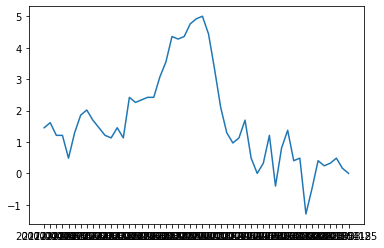

In [178]:
ETR = ExtraTreesRegressor()
ETR.fit(X_train,y_train)
predictions = ETR.predict(X_test)
print(r2_score(y_test,predictions))
plt.plot(dates_us[train_size_end:test_size_end],predictions)
plt.show()
plt.plot(dates_us[train_size_end:test_size_end],y_test)

-0.46379583216338593


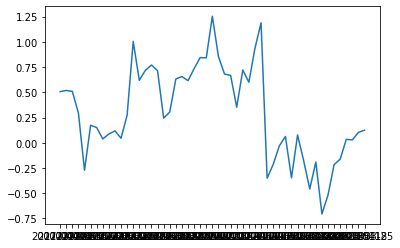

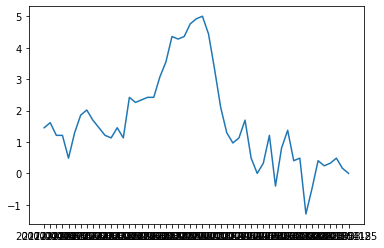

In [182]:
Svr = SVR(kernel ='rbf')
Svr.fit(X_train,y_train)
predictions = Svr.predict(X_test)
print(r2_score(y_test,predictions))
plt.plot(dates_us[train_size_end:test_size_end],predictions)
plt.show()
plt.plot(dates_us[train_size_end:test_size_end],y_test)

-0.08036728792804793


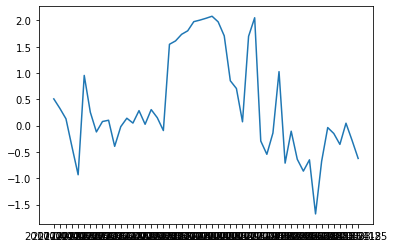

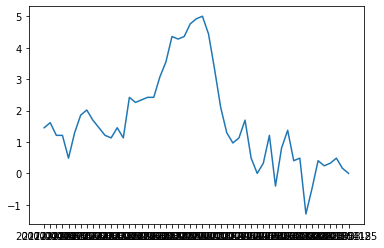

In [186]:
'''Generally the best performance is achived with Random Forests. Let's do a VotingRegressor '''
RFR =  RandomForestRegressor()
ETR = ExtraTreesRegressor()
AB = AdaBoostRegressor()
votingR = VotingRegressor(estimators=[('rfc', RFR),
('ETR', ETR),('AB',AB)],  n_jobs=-1)

votingR.fit(X_train, y_train)
predictions = votingR.predict(X_test)
print(r2_score(y_test,predictions))
plt.plot(dates_us[train_size_end:test_size_end],predictions)
plt.show()
plt.plot(dates_us[train_size_end:test_size_end],y_test)

In [ ]:
'''Algorithms correctly predict a big spike in prices somewhere near fall 2017. They correctly predict general behaviour of the time series.
I noticed that my models mistakenly assume a big spike in prices always when there is a trend of growing prices. My models are somewhat
decent and could be used for general prediction of avocado prices. Their predictions are correct for big spikes and falls of prices,
but where they fall off is in the little details eg. they do not fit well to small spikes in prices.'''